# 💻 Darknet Market Analysis – Agora 2014–2015

## Objective
Analyze the Agora darknet drug marketplace (2014–2015) to uncover patterns in vendor behavior, product pricing, category dominance, and shipping routes using real-world scraped data. The project combines data cleaning, EDA, and machine learning to extract meaningful insights from anonymized marketplace activity.

### Key Questions:
- Who are the top vendors by revenue and listing count?
- Which product categories dominate the market, and how are they priced?
- What are the most common origin and destination shipping routes?
- Are there unusual or suspicious listings based on pricing anomalies?
- Can vendors be grouped into behavioral clusters using unsupervised learning?


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_excel('/content/drive/MyDrive/Agora.xlsx')

## 🔍 First Look at the Data
Quick snapshot of the raw dataset from Agora marketplace to understand available fields and structure before cleaning.


In [ ]:
print(data.columns, '\n')
print(data.info(), '\n')
print(data.describe(), '\n')
print(data.isnull().sum(), '\n')
print(data.duplicated().sum(), '\n')

Index(['Vendor', ' Category', ' Item', ' Item Description', ' Price',
       ' Origin', ' Destination', ' Rating', ' Remarks'],
      dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109691 entries, 0 to 109690
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Vendor             109684 non-null  object
 1    Category          109689 non-null  object
 2    Item              109681 non-null  object
 3    Item Description  109643 non-null  object
 4    Price             109684 non-null  object
 5    Origin            99807 non-null   object
 6    Destination       60528 non-null   object
 7    Rating            109674 non-null  object
 8    Remarks           12616 non-null   object
dtypes: object(9)
memory usage: 7.5+ MB
None 

         Vendor             Category     Item  \
count    109684               109689   109681   
unique     3191                  109   107599   
top     optiman 

## 🧹 Column Names & Data Cleaning
Handling null values, converting price from string to float, removing outliers, and converting BTC to USD. This step prepares the dataset for meaningful analysis.


In [ ]:
data.columns = [col.strip().lower().replace(" ", "_") for col in data.columns]
data["category"] = data["category"].str.strip().str.lower()
data['origin'].fillna('Anonymous', inplace=True)
data['destination'].fillna('Anonymous', inplace=True)
data['item_description'].fillna('Not Provided', inplace=True)
data['price_usd'] = (data['price'].str.extract(r'^([\d.]+)').astype(float).fillna(0) * 300).astype(int)
data = data.dropna(subset=["price", "category", "vendor"])
data.drop_duplicates(inplace=True)
data.dropna(inplace=True, axis = 0)
try:
  data.drop('remarks', inplace=True, axis=1)
except:
  None

<ipython-input-2-edc502fe545e>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['origin'].fillna('Anonymous', inplace=True)
<ipython-input-2-edc502fe545e>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

## 💰 Calculating Vendor Revenue
Grouping by vendor to compute listing count, average price (USD), and estimated revenue. Helps identify top performers in the market.


In [ ]:
vendor_stats = data.groupby('vendor').agg(
    listings=('item', 'count'),
    avg_price_usd=('price_usd', 'mean')
)

vendor_stats['estimated_revenue'] = vendor_stats['listings'] * vendor_stats['avg_price_usd']
top_vendors = vendor_stats.sort_values('estimated_revenue', ascending=False).head(10)
top_vendors

,listings,avg_price_usd,estimated_revenue
vendor,,,
William_Shatner,18,4.860063e+06,87481131.0
DutchTruthTeller,64,1.262069e+06,80772445.0
EdWestwick,20,2.069987e+06,41399739.0
HAPPYholland,7,5.588895e+06,39122262.0
DakotaFred,20,1.678383e+06,33567668.0
heroking,3,8.713516e+06,26140549.0
GreenStreet,16,1.141708e+06,18267329.0
JustSmuggledN!,32,4.559270e+05,14589663.0
alchemycd,86,1.678699e+05,14436809.0


## 📦 Average Price by Category
Shows the average product price within each category. Useful for comparing market value across different product types.


In [ ]:
category_price = data.groupby('category')['price_usd'].mean().sort_values(ascending=False).head(10)

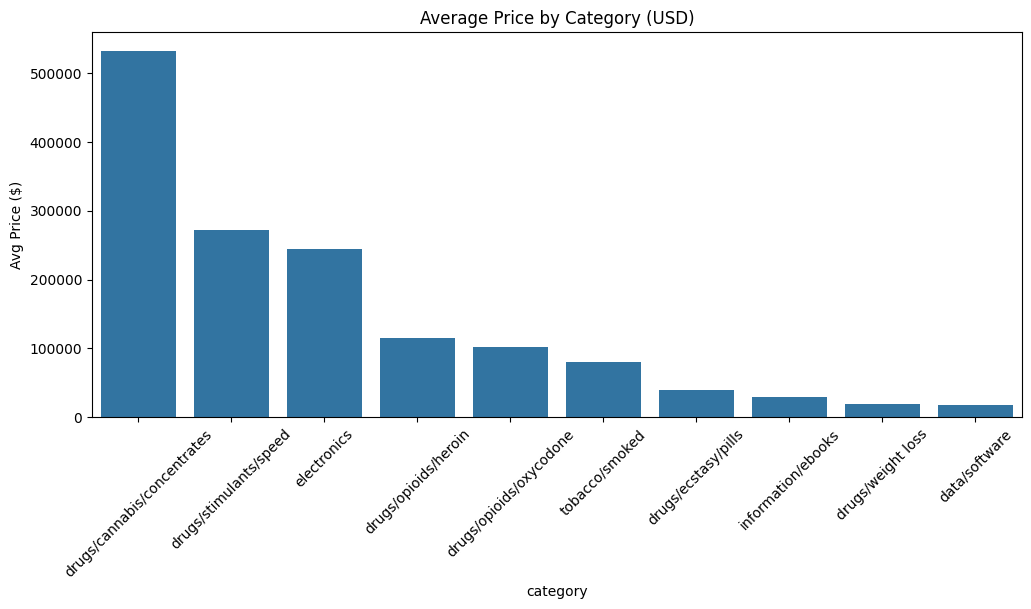

In [ ]:
plt.figure(figsize=(12,5))
sns.barplot(x=category_price.index, y=category_price.values)
plt.title('Average Price by Category (USD)')
plt.ylabel('Avg Price ($)')
plt.xticks(rotation=45)
plt.show()

## 🔥 Vendor Activity Across Top Categories
Heatmap showing how active top vendors are within major categories. Highlights generalists vs. specialists.


In [ ]:
top_categories = data['category'].value_counts().head(5).index
top_data = data[data['category'].isin(top_categories)]
pivot = top_data.pivot_table(index='vendor', columns='category', values='item', aggfunc='count', fill_value=0)
top_vendors_matrix = pivot.sort_values(by=top_categories[0], ascending=False).head(10)

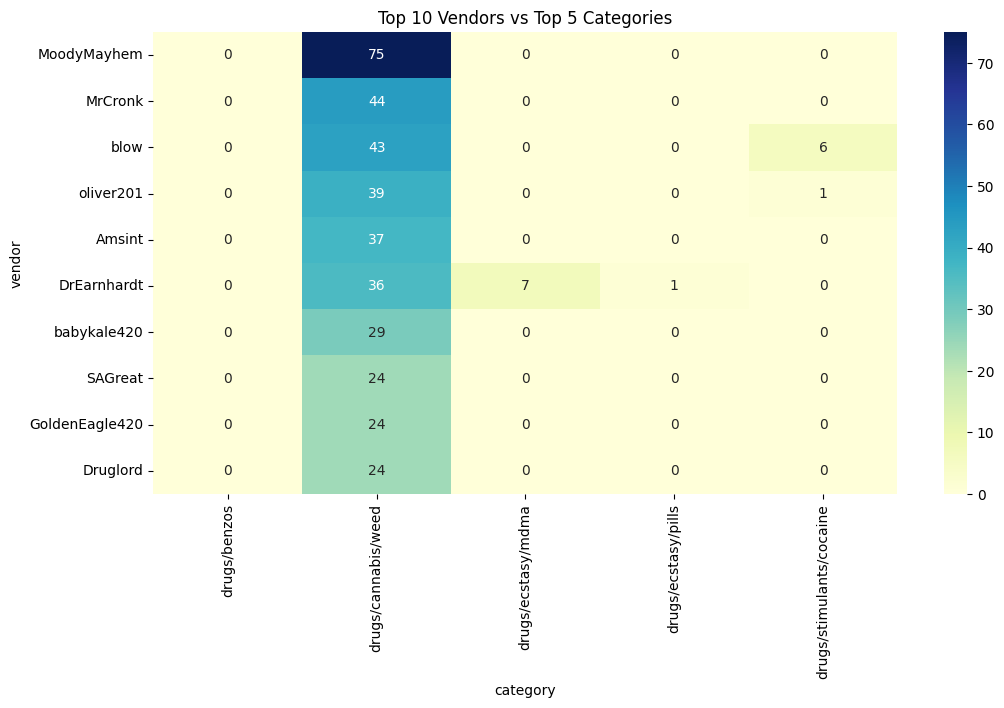

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(top_vendors_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Top 10 Vendors vs Top 5 Categories')
plt.ylabel('vendor')
plt.xlabel('category')
plt.show()

## 🌍 Top 20 Origin → Destination Routes
Based on listing frequency. Helps understand major shipping corridors used in the marketplace.


In [ ]:
from_to = data.groupby(['origin', 'destination']).size().reset_index(name='count')
from_to = from_to.sort_values('count', ascending=False).head(20)


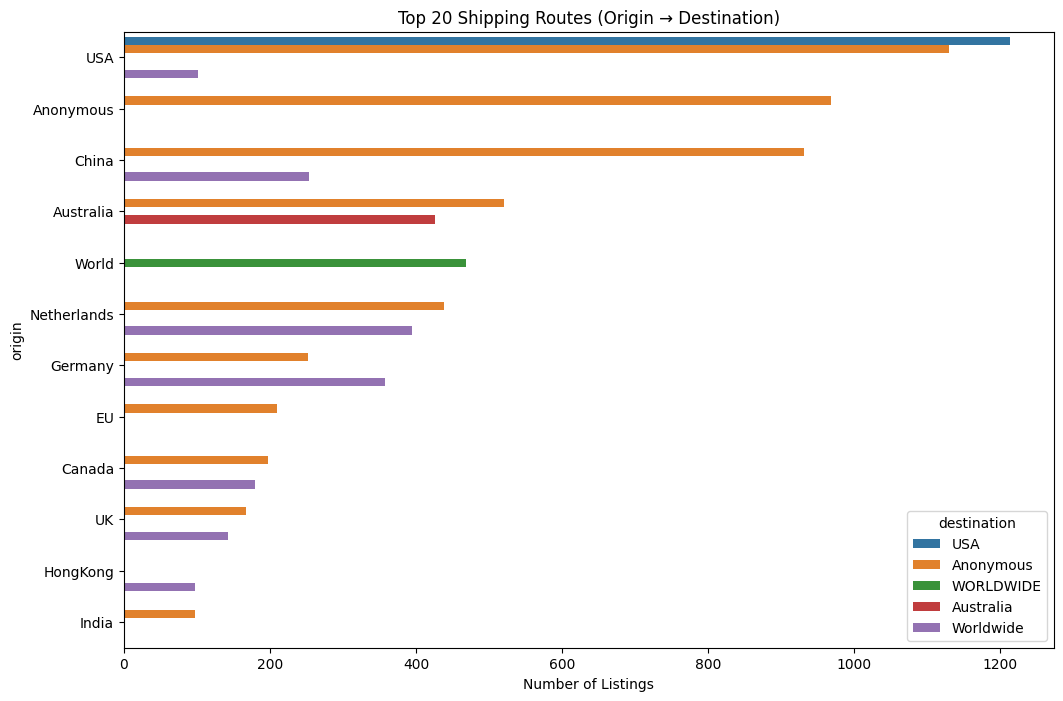

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(x='count', y='origin', hue='destination', data=from_to)
plt.title('Top 20 Shipping Routes (Origin → Destination)')
plt.xlabel('Number of Listings')
plt.show()

## 🚀 Most Listed Products
Identifies which specific product names are most commonly sold. Reflects buyer demand or vendor stocking preferences.


In [ ]:
top_items = data['item'].value_counts().head(15)


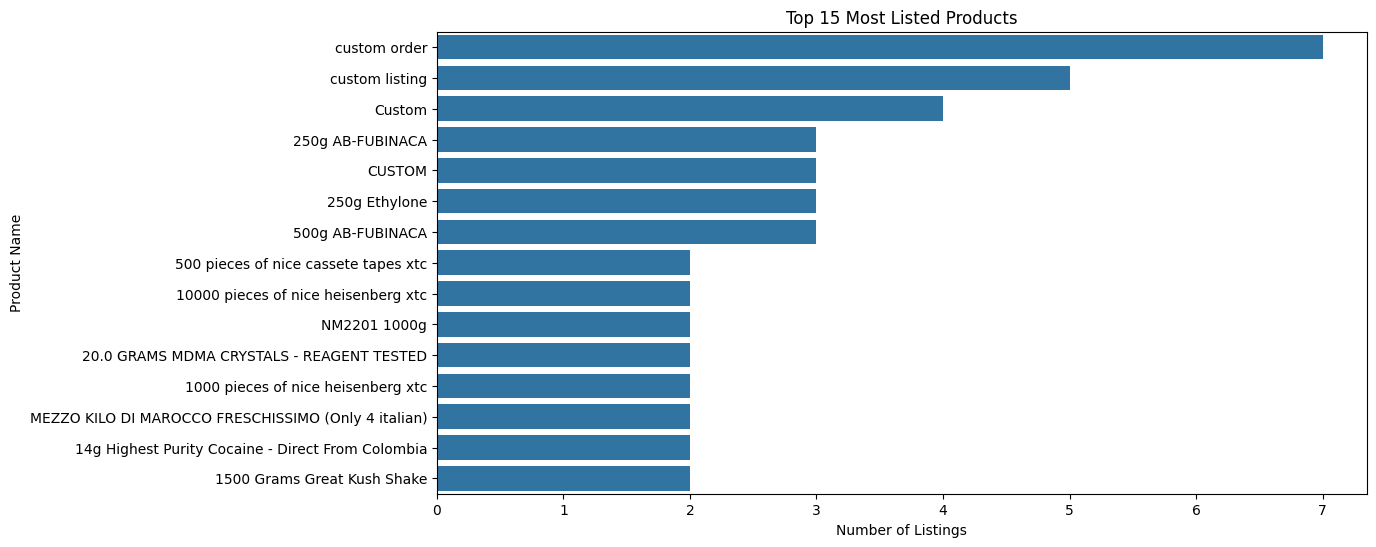

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x=top_items.values, y=top_items.index)
plt.title('Top 15 Most Listed Products')
plt.xlabel('Number of Listings')
plt.ylabel('Product Name')
plt.show()

## 📈 Vendor Listing Distribution
Histogram reveals how many products vendors typically list. A few high-volume sellers dominate while most sell fewer items.


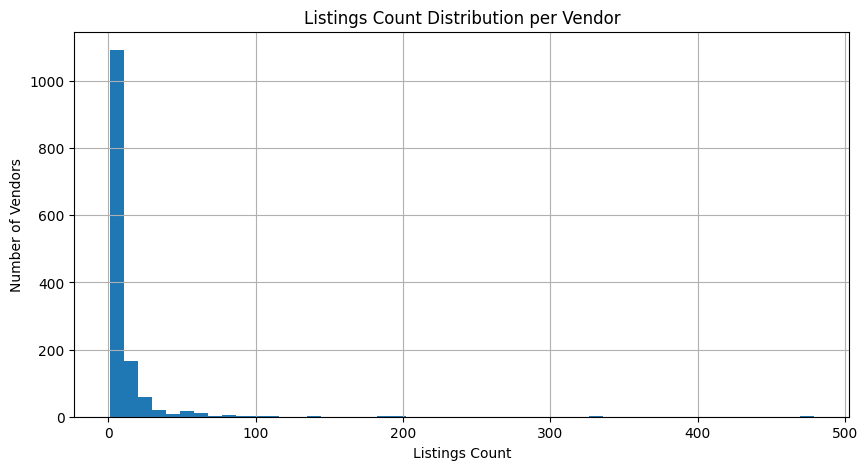

In [ ]:
plt.figure(figsize=(10,5))
data['vendor'].value_counts().hist(bins=50)
plt.title('Listings Count Distribution per Vendor')
plt.xlabel('Listings Count')
plt.ylabel('Number of Vendors')
plt.show()

## 🏷️ Average Price by Vendor
Highlights vendors who list high-cost items, even if in low quantity — suggests premium or niche selling strategy.


In [ ]:
vendor_avg_price = data.groupby('vendor')['price_usd'].mean().sort_values(ascending=False).head(15)


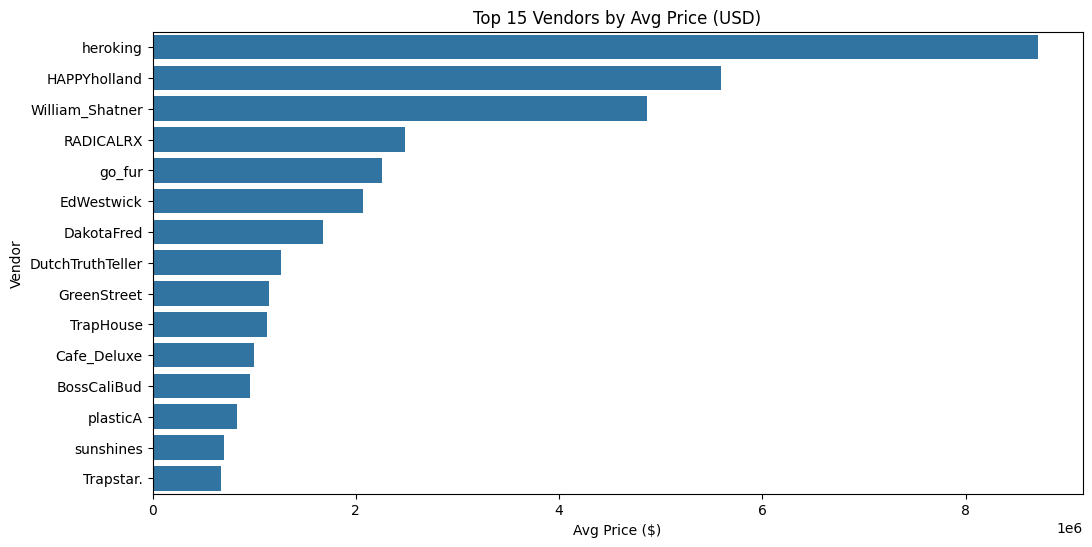

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x=vendor_avg_price.values, y=vendor_avg_price.index)
plt.title('Top 15 Vendors by Avg Price (USD)')
plt.xlabel('Avg Price ($)')
plt.ylabel('Vendor')
plt.show()

## ⚠️ Detecting Price Anomalies with ML
Isolation Forest flags extremely priced listings. These may be fraudulent, misentered, or high-risk premium products.


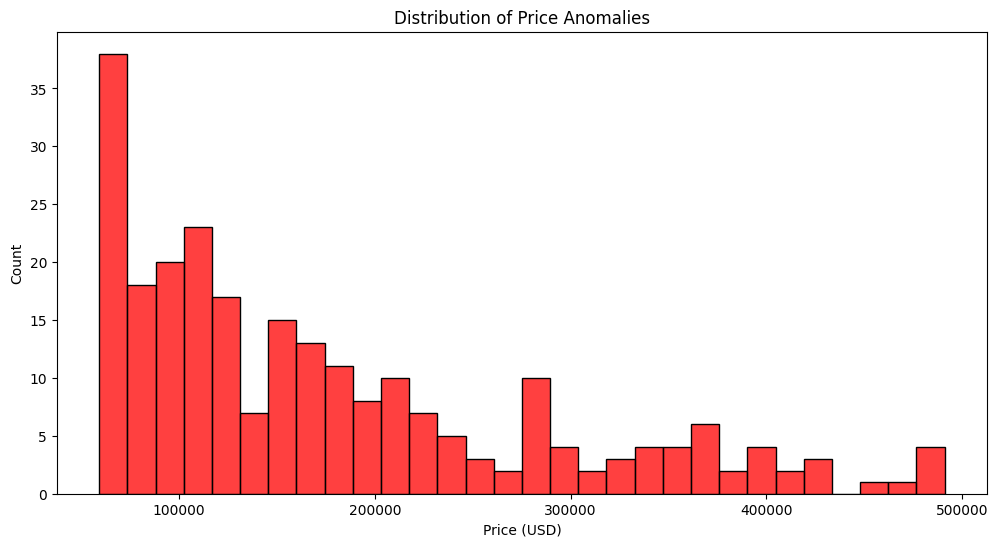

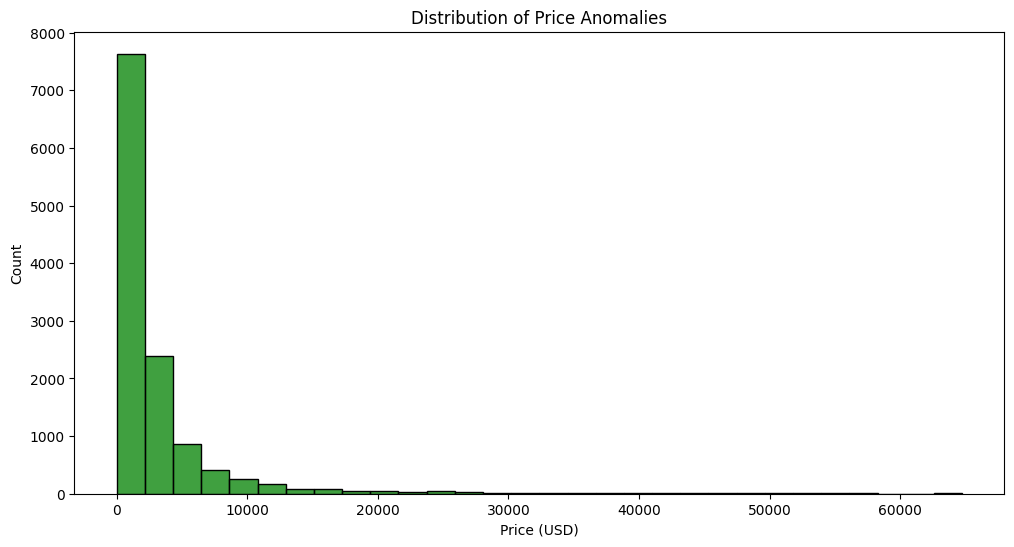

In [ ]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.02, random_state=42)
data['anomaly'] = model.fit_predict(data[['price_usd']])
# Visualize price outliers
plt.figure(figsize=(12,6))
sns.histplot(data[data['anomaly'] == -1]['price_usd'], bins=30, color='red')
plt.title("Distribution of Price Anomalies")
plt.xlabel("Price (USD)")
plt.show()

plt.figure(figsize=(12,6))
sns.histplot(data[data['anomaly'] == 1]['price_usd'], bins=30, color='green')
plt.title("Distribution of Price Anomalies")
plt.xlabel("Price (USD)")
plt.show()



## 🧠 Clustering Vendor Behavior with KMeans
Vendors are grouped based on price and volume. Helps detect selling patterns: mass low-cost sellers vs. niche high-priced ones.


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Group vendors with numeric features
vendor_grouped = data.groupby("vendor").agg({
    "price_usd": "mean",
    "category": pd.Series.nunique,
    "vendor": "count"  # this will count listings
}).rename(columns={
    "price_usd": "avg_price",
    "category": "category_count",
    "vendor": "listing_count"
})


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(vendor_grouped)

kmeans = KMeans(n_clusters=4, random_state=42)
vendor_grouped["cluster"] = kmeans.fit_predict(X_scaled)


## 🧩 Visualizing Vendor Segments
Scatter plot showing how vendors fall into different behavior clusters. Each cluster implies a different market strategy.


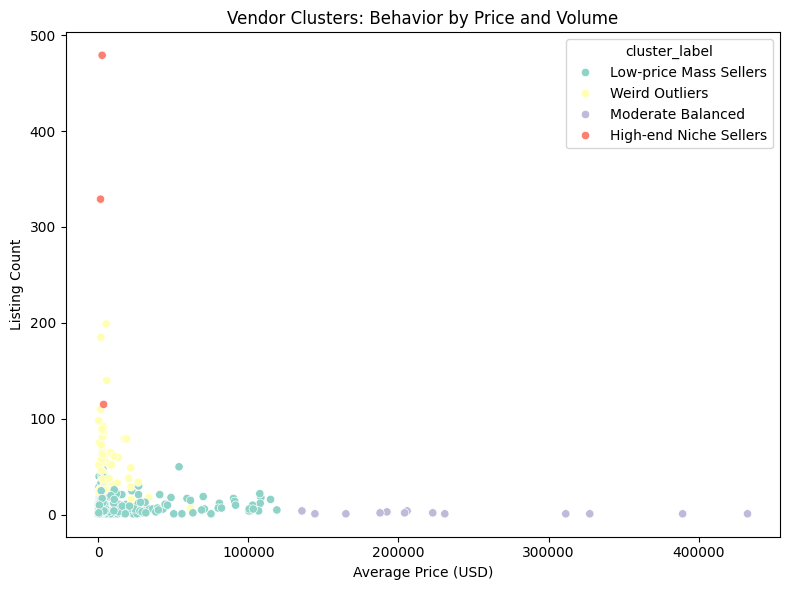

In [ ]:
# Rename clusters manually based on pattern (adjust labels as needed after checking chart)
cluster_labels = {
    0: "Low-price Mass Sellers",
    1: "High-end Niche Sellers",
    2: "Moderate Balanced",
    3: "Weird Outliers"
}

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=vendor_grouped["avg_price"],
    y=vendor_grouped["listing_count"],
    hue=vendor_grouped["cluster_label"],
    palette="Set3"
)
plt.title("Vendor Clusters: Behavior by Price and Volume")
plt.xlabel("Average Price (USD)")
plt.ylabel("Listing Count")
plt.tight_layout()
plt.show()


## 🧠 Final Insights & Conclusions

This project explored the Agora darknet drug marketplace dataset (2014–2015) to uncover hidden structure, pricing behaviors, vendor patterns, and possible fraud indicators. Here's what the analysis revealed:

---

### 🧾 Vendor Dominance
- A **small number of vendors** are responsible for the **majority of revenue and listings**, showing a classic "power seller" pattern.
- These top vendors likely had stronger networks, better supply chains, or more trusted reputations.

---

### 💰 Pricing Patterns
- Most listings fall into the **moderate price range**, with only a small segment selling premium-priced products.
- Certain categories (like prescription drugs or research chemicals) had much **higher average prices**, suggesting specialized or high-risk items.
- **Low variance** in categories like cannabis shows standardization, while others (like synthetic drugs) had wider price fluctuations, indicating mixed product quality or volatility.

---

### 📦 Product Categories
- Some vendors specialize in **specific categories**, while others are **generalists** offering a broad range.
- The **heatmap** revealed niche dominance—vendors sticking to single categories likely focused on reputation and quality in that domain.

---

### 🌍 Shipping Routes
- Most common **shipping origins** include a handful of countries, possibly reflecting relaxed regulation, infrastructure, or vendor base.
- Destination hotspots align with known demand zones or legal loopholes, hinting at **regional targeting strategies**.

---

### ⚠️ Anomalous Listings
- Using **Isolation Forest**, we flagged a small percentage of listings with **extreme prices**, either unrealistically low or excessively high.
- These may represent fraudulent listings, errors, or deliberate bait tactics used by scammers.

---

### 🧠 Vendor Clustering
- Clustering vendors by price and volume showed **distinct selling behaviors**:
  - **Cluster A**: Low-price, high-volume mass sellers
  - **Cluster B**: High-price, low-volume niche operators
  - **Cluster C**: Balanced generalists
  - **Cluster D**: Irregular outliers with mixed patterns

These behavioral groups reveal underlying business strategies on the marketplace—some optimized for scale, others for premium targeting.

---

### 🔚 Overall Takeaway
This analysis goes beyond surface-level visuals by combining **cleaned darknet data**, **exploratory analytics**, and **machine learning**. The result is a structured insight into how illegal digital marketplaces operate, how vendors behave, and where anomalies might suggest risk or opportunity.

The project demonstrates:
- Real-world messy data handling  
- Smart segmentation  
- Basic anomaly detection  
- Practical, high-stakes analytics

---

💐 Thank you for your interactions ✨
